In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.optim import Optimizer, Adam
from torch.types import Number
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.models as models

In [18]:
from typing import cast, Any, overload, Generic
from typing_extensions import TypeVar
from matplotlib.figure import Figure
from matplotlib.axes import Axes

T_co = TypeVar("T_co", covariant=True, default=Tensor)

In [19]:
from tqdm.notebook import tqdm

In [20]:
project_name = "project-plant-identification"

In [21]:
from modules.dataset import (
    DATASET_BASEDIR,
    DATASET_DIR,
    DATASET_AUGMENTED_DIR,
    DATASET_ORIG_DIR,
    UNIQUE_PLANTS,
)
from modules.dataset import TRANSFORM
from modules.dataset import inv_norm


os.listdir(DATASET_BASEDIR)

['Flavia', 'New Plant-Dataset', 'Random']

In [22]:
os.listdir(DATASET_DIR)

['augmented',
 'augmented_features.csv',
 'original',
 'processed_features.csv',
 'rcnn_dataset.bin',
 'rcnn_dataset.csv',
 'rcnn_dataset_2.csv',
 'valid',
 'Z',
 'ZZ']

In [23]:
_classes = os.listdir(DATASET_AUGMENTED_DIR)
_classes

['Arjun Leaf',
 'Curry Leaf',
 'Marsh Pennywort Leaf',
 'Mint Leaf',
 'Neem Leaf',
 'Rubble Leaf']

In [24]:
from statistics import mean


AVERAGE_NUMBER_OF_IMAGES = mean(
    len(os.listdir(DATASET_AUGMENTED_DIR / i))
    for i in os.listdir(DATASET_AUGMENTED_DIR)
)
AVERAGE_NUMBER_OF_IMAGES

1610

In [25]:
print("Number of Classes: ", len(UNIQUE_PLANTS))
print("Classes: ", UNIQUE_PLANTS)

Number of Classes:  6
Classes:  ['Arjun Leaf', 'Curry Leaf', 'Marsh Pennywort Leaf', 'Mint Leaf', 'Neem Leaf', 'Rubble Leaf']


In [26]:
dataset = ImageFolder(str(DATASET_AUGMENTED_DIR), transform=TRANSFORM)
orig_ds = ImageFolder(str(DATASET_ORIG_DIR), transform=TRANSFORM)

In [27]:
print("Number of training images: ", len(dataset))
print("Number of original images: ", len(orig_ds))

Number of training images:  9660
Number of original images:  1380


In [28]:
num_classes = dataset.classes
print("Number of classes: ", len(num_classes))
print(*num_classes, sep="\n")

Number of classes:  6
Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf


In [29]:
print(*orig_ds.classes, sep="\n")

Arjun Leaf
Curry Leaf
Marsh Pennywort Leaf
Mint Leaf
Neem Leaf
Rubble Leaf


Image shape: torch.Size([3, 256, 256])
Image Label:  0
Image Label:  Arjun Leaf


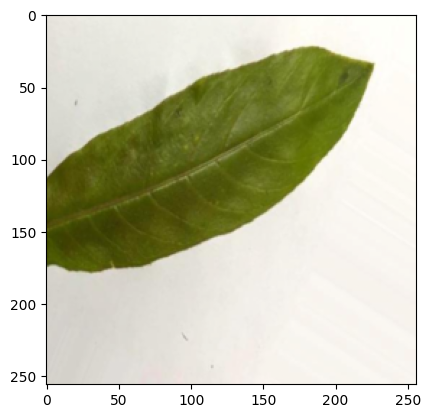

In [30]:
image, label = dataset[0]
print("Image shape:", image.shape)
print("Image Label: ", label)
print("Image Label: ", num_classes[label])
plt.imshow(inv_norm(image).permute(1, 2, 0))

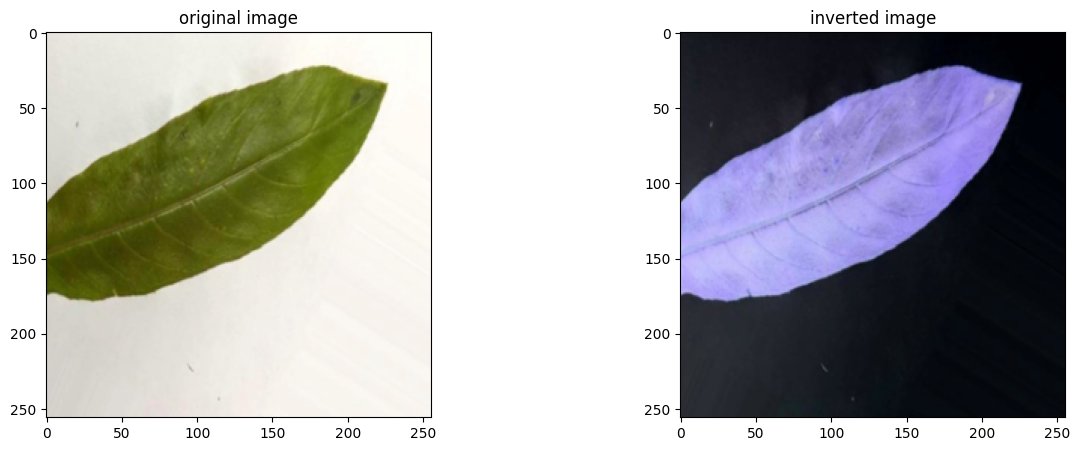

In [31]:
fig, (ax1, ax2) = cast(
    tuple[Figure, tuple[Axes, Axes]], plt.subplots(figsize=(15, 5), nrows=1, ncols=2)
)
unnormalized_image = inv_norm(image)
ax1.imshow(unnormalized_image.permute(1, 2, 0))
ax1.set_title("original image")
ax2.imshow(1 - unnormalized_image.permute(1, 2, 0))
ax2.set_title("inverted image")
plt.show()

In [32]:
random_seed = 42
torch.manual_seed(random_seed)  # type: ignore

In [33]:
dataset_length = len(dataset)
validation_split = 0.3
val_size = int(dataset_length * validation_split)
train_size = dataset_length - val_size


dataset_length, train_size, val_size, dataset_length == train_size + val_size

(9660, 6762, 2898, True)

In [34]:
TRAIN_DATASET, TEST_DATASET = random_split(dataset, (train_size, val_size))

In [20]:
batch_size = 64

TRAIN_LOADER = DataLoader(
    TRAIN_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
TEST_LOADER = DataLoader(
    TEST_DATASET, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)
ORIG_LOADER = DataLoader(
    orig_ds, batch_size=batch_size, num_workers=2, shuffle=True, pin_memory=True
)

for x in TRAIN_LOADER:
    print(type(x), len(x), x)
    # print(len(x[0]), len(x[1]))
    break

<class 'list'> 2 [tensor([[[[1.7694, 1.7694, 1.7523,  ..., 1.4954, 1.5297, 1.5468],
          [1.7694, 1.7694, 1.7523,  ..., 1.5297, 1.5468, 1.5639],
          [1.7694, 1.7694, 1.7523,  ..., 1.5468, 1.5468, 1.5468],
          ...,
          [1.3927, 1.3927, 1.3927,  ..., 0.9988, 1.0159, 0.9988],
          [1.3927, 1.3927, 1.3927,  ..., 0.9988, 1.0159, 1.0159],
          [1.3927, 1.3927, 1.3927,  ..., 0.9988, 1.0159, 1.0331]],

         [[1.8508, 1.8508, 1.8333,  ..., 1.5007, 1.5357, 1.5532],
          [1.8508, 1.8508, 1.8333,  ..., 1.5357, 1.5532, 1.5707],
          [1.8508, 1.8508, 1.8333,  ..., 1.5532, 1.5532, 1.5532],
          ...,
          [1.4657, 1.4657, 1.4657,  ..., 1.0630, 1.0805, 1.0630],
          [1.4657, 1.4657, 1.4657,  ..., 1.0630, 1.0805, 1.0805],
          [1.4657, 1.4657, 1.4657,  ..., 1.0630, 1.0805, 1.0980]],

         [[1.9603, 1.9603, 1.9428,  ..., 1.6291, 1.6640, 1.6814],
          [1.9603, 1.9603, 1.9428,  ..., 1.6640, 1.6814, 1.6988],
          [1.9603, 1.960

In [21]:
# for images, labels in TRAIN_LOADER:
#     fig, ax = plt.subplots(figsize=(20, 8))
#     ax.imshow(make_grid(inv_norm(images.cpu()), nrow=16).permute(1, 2, 0))
#     break

In [22]:
def accuracy(outputs: Tensor, labels: Tensor):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
from modules.device import DEVICE, to_device
from modules.device import DeviceDataLoader


DEVICE

device(type='cuda')

In [24]:
TRAIN_LOADER = DeviceDataLoader(TRAIN_LOADER, DEVICE)
TEST_LOADER = DeviceDataLoader(TEST_LOADER, DEVICE)
ORIG_LOADER = DeviceDataLoader(ORIG_LOADER, DEVICE)

In [25]:
from modules.herbal_image_classification import HerbalIdentificationModel2, ImageClassificationBase


model = to_device(HerbalIdentificationModel2(), DEVICE)

d:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [26]:
model

HerbalIdentificationModel2(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, aff

In [27]:
@torch.no_grad()  # type: ignore
def evaluate(model: ImageClassificationBase, val_loader: DeviceDataLoader[Tensor]):
    model.eval()
    outputs = [model.validation_step(batch[0], batch[1]) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [28]:
def fit(
    epochs: int,
    model: ImageClassificationBase,
    train_loader: DeviceDataLoader[Tensor],
    val_loader: DeviceDataLoader[Tensor],
    optimizer: Optimizer,
):
    history: list[dict[str, Number]] = []
    for epoch in range(epochs):
        model.train()
        train_losses: list[Tensor] = []
        for batch in tqdm(train_loader): # type: ignore
            images, labels = batch
            loss = model.training_step(images, labels)
            train_losses.append(loss)
            loss.backward()  # type: ignore
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result["train_loss"] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [29]:
history = fit(25, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

  0%|          | 0/106 [00:00<?, ?it/s]

<class 'list'> 2 [tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [1.8550, 1.8550, 1.8550,  ..., 2.2489, 2.2489, 2.2489],
          [1.8379, 1.8379, 1.8379,  ..., 2.2489, 2.2489, 2.2489],
          [1.8208, 1.8208, 1.8208,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [1.9384, 1.9384, 1.9384,  ..., 2.4286, 2.4286, 2.4286],
          [1.9209, 1.9209, 1.9209,  ..., 2.4286, 2.4286, 2.4286],
          [1.9034, 1.9034, 1.9034,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.640

In [122]:
# evaluate(model, TEST_LOADER)

In [123]:
# history = fit(5, model, TRAIN_LOADER, TEST_LOADER, Adam(model.parameters(), 0.001))

In [124]:
def plot_losses(history: list[dict[str, Number]]):
    train_losses = [x["train_loss"] for x in history]
    val_losses = [x["val_loss"] for x in history]
    plt.plot(train_losses, "-bx")
    plt.plot(val_losses, "-rx")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of epochs")

In [125]:
def plot_accuracies(history: list[dict[str, Number]]):
    accuracies = [x["val_acc"] for x in history]
    plt.plot(accuracies, "-x")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracy vs. No. of epochs")

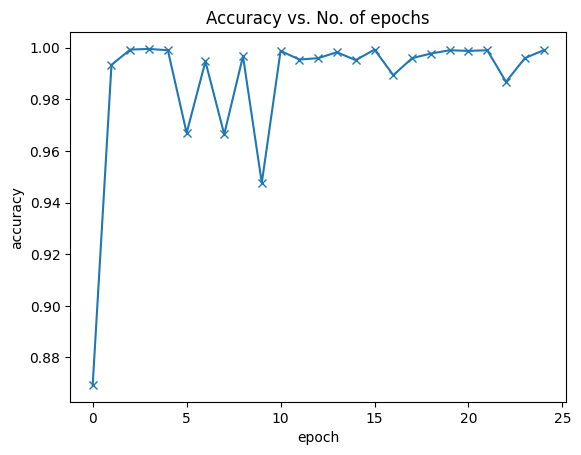

In [126]:
plot_accuracies(history)

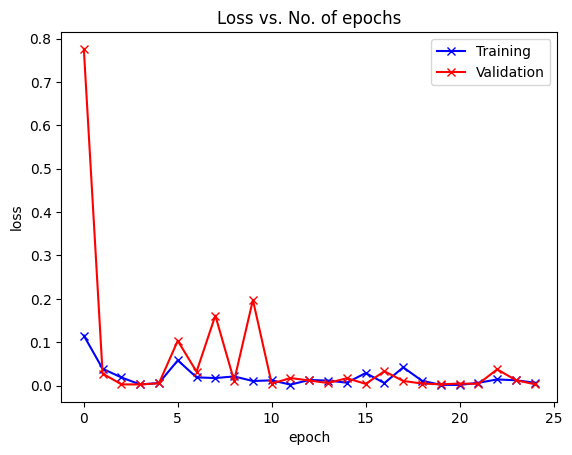

In [127]:
plot_losses(history)

In [128]:
evaluate(model, TEST_LOADER)

{'val_loss': 0.003336370224133134, 'val_acc': 0.998975396156311}

In [129]:
x = evaluate(model, ORIG_LOADER)
x

{'val_loss': 0.0003959198947995901, 'val_acc': 1.0}

In [130]:
def predict_image(img: Tensor, model: ImageClassificationBase):
    xb = to_device(img.unsqueeze(0), DEVICE)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    i = cast(int, preds[0].item())
    print(i, type(i))
    return dataset.classes[i]

0 <class 'int'>
Label: Arjun Leaf , Predicted: Arjun Leaf


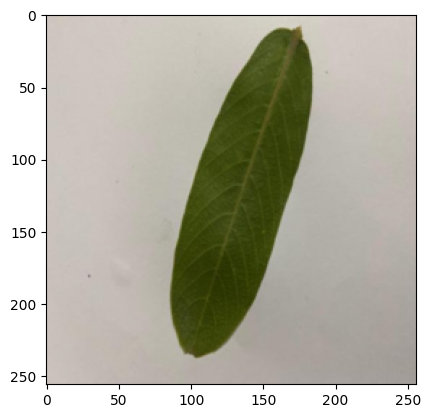

In [131]:
img, label = orig_ds[25]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

4 <class 'int'>
Label: Neem Leaf , Predicted: Neem Leaf


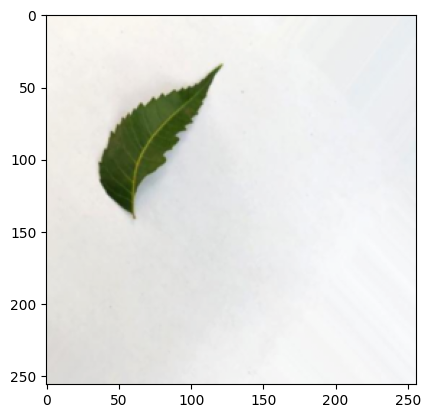

In [132]:
img, label = TRAIN_DATASET[25]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

4 <class 'int'>
Label: Neem Leaf , Predicted: Neem Leaf


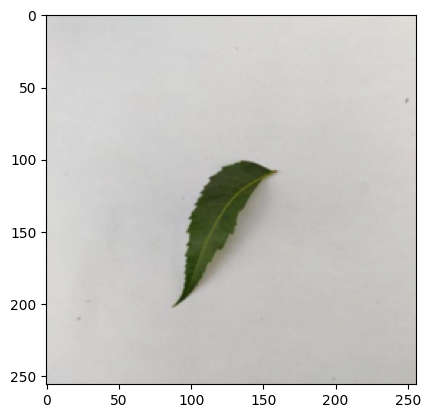

In [133]:
img, label = orig_ds[978]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

1 <class 'int'>
Label: Curry Leaf , Predicted: Curry Leaf


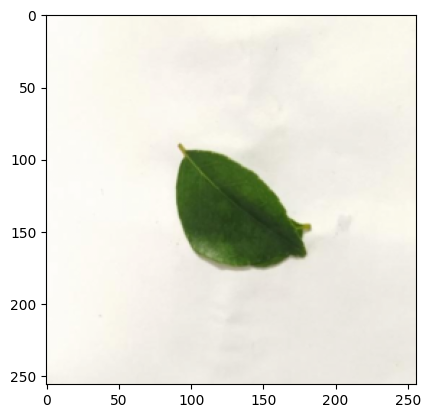

In [134]:
img, label = orig_ds[258]
plt.imshow(inv_norm(img).permute(1, 2, 0))
print("Label:", dataset.classes[label], ", Predicted:", predict_image(img, model))

In [135]:
print(len(orig_ds))

1380


In [136]:
for i in range(len(orig_ds)):
    path, target = orig_ds.samples[i]
    print("Sample {}: Path: {}, Target: {}".format(i, path, target))

Sample 0: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (1).JPG, Target: 0
Sample 1: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (10).JPG, Target: 0
Sample 2: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (100).JPG, Target: 0
Sample 3: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (101).JPG, Target: 0
Sample 4: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (102).JPG, Target: 0
Sample 5: Path: D:\.R5-3600-Desktop\Documents\Code\ACLC-Butuan\Other\Herbal-Identification\dataset\New Plant-Dataset\original\Arjun Leaf\Arjun Leaf (103).JPG,

In [137]:
torch.save(model.state_dict(), "../models/herbal-identification-new-resnet34.pth")

In [138]:
x = [x]

# Check the content and structure of x
print(x)

# Verify the data type of x[0]
print(type(x[0]))

# Assuming x[0] is a dictionary, access the keys 'val_acc' and 'val_loss'
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
else:
    print("x[0] is not a dictionary as expected.")

[{'val_loss': 0.0003959198947995901, 'val_acc': 1.0}]
<class 'dict'>
Test Accuracy: 1.0
Test Loss: 0.0003959198947995901


In [139]:
if isinstance(x[0], dict):
    test_acc = x[0].get("val_acc")
    test_loss = x[0].get("val_loss")
    print("Test Accuracy:", test_acc)
    print("Test Loss:", test_loss)
elif isinstance(x[0], str):
    print("Evaluation result is a string:", x[0])
    # Handle the string result accordingly
else:
    print("Unexpected type for x[0]:", type(x[0]))

Test Accuracy: 1.0
Test Loss: 0.0003959198947995901
